In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def MinimumFilter(src, r=7):
    return cv2.erode(src, np.ones((2*r+1, 2*r+1))) 

def GuidedFilter(I, p, r, eps):
    height, width = I.shape
    m_I = cv2.boxFilter(I, -1, (r,r))
    m_p = cv2.boxFilter(p, -1, (r,r))
    m_Ip = cv2.boxFilter(I*p, -1, (r,r))
    cov_Ip = m_Ip-m_I*m_p
    
    m_II = cv2.boxFilter(I*I, -1, (r,r))
    var_I = m_II-m_I*m_I
    
    a = cov_Ip/(var_I+eps)
    b = m_p-a*m_I
    m_a = cv2.boxFilter(a, -1, (r,r))
    m_b = cv2.boxFilter(b, -1, (r,r))
    
    return m_a*I+m_b

def returnV1(m, r, eps, w, maxV1):
    V1 = np.min(m,2)
    V1 = GuidedFilter(V1, MinimumFilter(V1,7), r, eps)
    bins = 2000
    ht = np.histogram(V1, bins)
    d = np.cumsum(ht[0])/float(V1.size)
    for lmax in range(bins-1, 0, -1):
        if d[lmax]<=0.999:
            break
    A  = np.mean(m,2)[V1>=ht[1][lmax]].max()
    V1 = np.minimum(V1*w, maxV1)
      
    return V1, A
  
# 图像去雾
def deHaze(m, r=81, eps=0.001, w=0.95, maxV1=0.80, bGamma=False):
    deh = np.zeros(m.shape)
    V1, A = returnV1(m, r, eps, w, maxV1)
    for k in range(3):
        deh[:,:,k] = (m[:,:,k]-V1)/(1-V1/A)
    deh =  np.clip(deh, 0, 1)
    if bGamma:
        deh = deh**(np.log(0.5)/np.log(deh.mean()))
    return deh
  


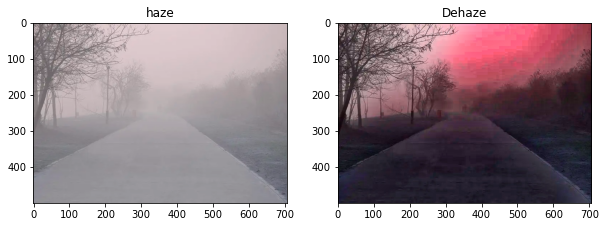

In [6]:
m = deHaze(cv2.imread('haze.jpg')/255.0)*255
cv2.imwrite('dehaze.jpg', m)

plt.figure(figsize=(10, 12))

haze = cv2.imread('haze.jpg')
dehaze = cv2.imread('dehaze.jpg')

plt.subplot(121)
plt.imshow(haze)
plt.title('haze')
# plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(dehaze)
plt.title('Dehaze')
# plt.xticks([]), plt.yticks([])
plt.show()
